In [1]:
from md4.configs.hollow_md4.text8 import get_config
from collections.abc import Callable, Mapping, Sequence
import copy
import functools
from typing import Any

from absl import logging
from clu import metric_writers
from clu import metrics
from clu import parameter_overview
from clu import periodic_actions
from etils import epath
import flax
import flax.jax_utils as flax_utils
import flax.linen as nn
import grain.python as graåçin
import jax
from jax.experimental import checkify
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
from orbax import checkpoint as orbax_checkpoint

from md4 import input_pipeline
from md4 import input_pipeline_v2
from md4 import sampling
from md4 import utils
from md4.models import utils as model_utils

from md4.train import *
from md4.train import _get_checkpoint_manager

import pickle
from tqdm import tqdm

config = get_config()
workdir = "/root/md4/expt_contantlr_deeper__model_untie"

2025-04-05 09:34:48.003566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743845688.016845  390356 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743845688.021139  390356 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743845688.032458  390356 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743845688.032471  390356 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743845688.032472  390356 computation_placer.cc:177] computation placer alr

cv2 not found


In [2]:
workdir = epath.Path(workdir)
workdir.mkdir(parents=True, exist_ok=True)

rng = utils.get_rng(config.seed)
logging.info("Using random seed %s.", rng)
writer = metric_writers.create_default_writer(
    workdir, just_logging=jax.process_index() > 0
)

# Learning rate schedule.
assert config.batch_size % jax.device_count() == 0
per_device_batch_size = config.batch_size // jax.device_count()
num_train_steps = input_pipeline.get_num_train_steps(config)
steps_per_epoch = num_train_steps // config.num_epochs
logging.info("num_train_steps=%d, steps_per_epoch=%d", num_train_steps, steps_per_epoch)
schedule_fn = functools.partial(
    get_learning_rate,
    base_learning_rate=config.learning_rate,
    num_steps=num_train_steps,
    warmup_steps=config.warmup_steps,
    schedule_type=config.learning_rate_schedule,
)

# Build input pipeline.
rng, data_seed = jax.random.split(rng)
data_seed = int(
    jax.random.randint(data_seed, [], minval=0, maxval=np.iinfo(np.int32).max)
)
# The input pipeline runs on each process and loads data for local TPUs.
create_datasets = (
    input_pipeline_v2.create_datasets
    if config.get("use_v2_input_pipeline", None)
    else input_pipeline.create_datasets
)
train_loader, eval_loaders, dataset_info = create_datasets(config, data_seed)

train_iter = iter(train_loader)

# Initialize model.
rng, model_rng = jax.random.split(rng)
data_shape = input_pipeline.get_data_shape(config)
# Note: parameters are initialized in half precision if mixed_precision_training=True
# We could also try casting them to half precision here
model, optimizer, train_state, metrics_class = (
    create_train_state(  # pylint: disable=invalid-name
        config,
        model_rng,
        input_shape=(per_device_batch_size // config.num_microbatches,) + data_shape,
        schedule_fn=schedule_fn,
    )
)

# Set up checkpointing of the model and the input pipeline.
checkpoint_manager = _get_checkpoint_manager(config, workdir)

# Retrieve data from previous checkpoints if possible.
checkpointed_state = dict(train_state=train_state, train_iter=train_iter)
if checkpoint_manager.latest_step() is not None:
    checkpointed_state = checkpoint_manager.restore(
        checkpoint_manager.latest_step(), items=checkpointed_state
    )
train_state = checkpointed_state["train_state"]
train_iter = checkpointed_state["train_iter"]

I0000 00:00:1743845702.731844  390356 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 92886 MB memory:  -> device: 0, name: NVIDIA H100 NVL, pci bus id: 0000:03:00.0, compute capability: 9.0
I0000 00:00:1743845702.733949  390356 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 92898 MB memory:  -> device: 1, name: NVIDIA H100 NVL, pci bus id: 0000:04:00.0, compute capability: 9.0
I0000 00:00:1743845702.735842  390356 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 92898 MB memory:  -> device: 2, name: NVIDIA H100 NVL, pci bus id: 0000:63:00.0, compute capability: 9.0
I0000 00:00:1743845702.737748  390356 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 92898 MB memory:  -> device: 3, name: NVIDIA H100 NVL, pci bus id: 0000:64:00.0, compute capability: 9.0
I0000 00:00:1743845702.739589  390356 gpu_device.cc:2019] Created device /job:localhost/

In [3]:
# Distribute training.
train_state = flax_utils.replicate(train_state)
train_step_func = functools.partial(
    train_step,
    model=model,
    optimizer=optimizer,
    train_metrics_class=metrics_class,
    learning_rate_fn=schedule_fn,
    ema_rate=config.ema_rate,
    num_microbatches=config.get("num_microbatches", None),
)
if config.check_nans:
    train_step_func = checkify.checkify(train_step_func, errors=checkify.float_checks)
p_train_step = jax.pmap(train_step_func, axis_name="batch", donate_argnums=(0,))
p_eval_step = jax.pmap(
    functools.partial(
        eval_step,
        model=model,
        eval_metrics_class=metrics_class,
        ema_rate=config.ema_rate,
    ),
    axis_name="batch",
)

hooks = []
report_progress = periodic_actions.ReportProgress(
    num_train_steps=num_train_steps, writer=writer
)
if jax.process_index() == 0:
    hooks += [
        report_progress,
        periodic_actions.Profile(num_profile_steps=5, logdir=workdir),
    ]
train_metrics = None

# Unreplicating from TPU is costly, so we only do it once at the start.
initial_step = int(flax.jax_utils.unreplicate(train_state.step))

In [4]:
batch = utils.reshape_batch(next(train_iter))

if config.check_nans:
    errs, (train_state, metrics_update) = p_train_step(
        train_state=train_state, batch=batch
    )
    errs.throw()
else:
    train_state, metrics_update = p_train_step(train_state=train_state, batch=batch)
metric_update = flax_utils.unreplicate(metrics_update)

train_metrics = (
    metric_update if train_metrics is None else train_metrics.merge(metric_update)
)

2025-04-05 09:35:43.439378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743845743.452642  392739 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743845743.456925  392739 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743845743.468179  392739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743845743.468199  392739 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743845743.468201  392739 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
batch_size 64
cv2 not found


In [16]:
model.sampler = "gibbs"

results_dict = {}

k_range = [1, 2, 4, 8, 16]
tem_range = [0.1, 1.0, 2.0, 10.0, 1000.0]

# for k in k_range:
#     for tem in tem_range:
#         results_dict[k, tem] = {}

timesteps = 256
model.timesteps = timesteps // 2

for k in tqdm(k_range):
    for tem in tqdm(tem_range):
        model.k = k
        model.gibbs_temp = tem
        # for timesteps in tqdm([16, 32, 64, 128, 256]):
        #     model.timesteps = timesteps
        # with report_progress.timed("sample"):
        _, sample_rng = jax.random.split(rng)
        dummy_loader = train_loader
        dummy_batch = utils.reshape_batch(next(iter(dummy_loader)))
        dummy_inputs = dummy_batch[config.task_type]
        if "label" in dummy_batch:
            conditioning = dummy_batch["label"].astype("int32")
        else:
            conditioning = None

        samples = sampling.generate(
            model,
            train_state,
            flax_utils.replicate(sample_rng),
            dummy_inputs,
            conditioning=conditioning,
        )

        all_samples = jax.pmap(
            lambda x: jax.lax.all_gather(x, "batch"), axis_name="batch"
        )(samples)
        all_samples = flax_utils.unreplicate(all_samples)
        all_samples = all_samples.reshape(-1, *data_shape)

        tokenizer = dataset_info["tokenizer"]
        texts = utils.detokenize_texts(all_samples, tokenizer)
        results_dict[k, tem] = texts

  0%|          | 0/5 [00:00<?, ?it/s]2025-04-05 12:30:06.837761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:30:06.847044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743856206.851508  681616 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743856206.855868  681616 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 12:30:06.858684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has alre

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:32:01.827219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743856321.840941  684543 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743856321.845329  684543 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743856321.856973  684543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743856321.856988  684543 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743856321.856990  684543 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:33:58.277055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743856438.291074  687293 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743856438.295616  687293 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743856438.308153  687293 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743856438.308172  687293 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743856438.308174  687293 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:35:56.275682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:35:56.284685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:35:56.286320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743856556.289567  690255 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743856556.294044  690255 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:17438

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:37:53.740175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:37:53.748279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:37:53.748305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743856673.754047  693162 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 12:37:53.757055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 20%|██        | 1/5 [09:42<38:51, 582.88s/it]2025-04-05 12:39:49.782082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743856789.795623  696061 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743856789.799972  696061 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 12:39:49.809733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1743856789.811322  696061 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:41:47.444466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:41:47.447403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:41:47.447570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:41:47.447954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:41:47.452607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:43:51.350161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:43:51.353848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:43:51.353850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:43:51.360949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857031.364284  701815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:45:46.224032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:45:46.231959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857146.237962  704665 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743857146.242467  704665 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1743857146.245618  704662 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 12:45:46.246721: E external/local_xla/xla

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:47:43.620647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:47:43.622645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857263.633830  707594 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743857263.636062  707586 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743857263.638111  707594 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1743857263.640438  707586 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 40%|████      | 2/5 [19:41<29:36, 592.20s/it]2025-04-05 12:49:48.459327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:49:48.467289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857388.472973  710558 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 12:49:48.473798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857388.477381  710558 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:51:43.827856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:51:43.831318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:51:43.831319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:51:43.841588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857503.844953  713485 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:53:40.181364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857620.195127  716245 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743857620.199548  716245 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743857620.211656  716245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743857620.211677  716245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743857620.211680  716245 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:55:38.134597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 12:55:38.140819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857738.147750  719184 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 12:55:38.149360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857738.152025  719184 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:17438

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 12:57:33.969871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857853.983239  722089 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743857853.987494  722089 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743857853.998650  722089 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743857853.998667  722089 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743857853.998669  722089 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 60%|██████    | 3/5 [29:30<19:41, 590.67s/it]2025-04-05 12:59:37.299734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743857977.312899  724851 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743857977.317193  724851 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743857977.328601  724851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743857977.328617  724851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743857977.328618  724851 com

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 13:01:34.950557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:01:34.951384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:01:34.962328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858094.963838  727711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858094.964597  727704 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 13:01:34.

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 13:02:18.130765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:02:18.134975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:02:18.142748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:02:18.143662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858138.144042  730183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 13:04:13.030103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:04:13.041830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858253.043868  732984 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858253.048242  732984 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1743858253.055409  732995 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858253.059727  732995 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 13:06:10.461619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:06:10.466382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858370.475222  735889 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858370.479611  735889 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1743858370.480297  735890 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858370.484726  735890 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 80%|████████  | 4/5 [38:02<09:19, 559.52s/it]2025-04-05 13:08:09.006386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:08:09.019365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858489.019962  738743 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858489.024342  738743 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1743858489.032644  738753 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
W0000 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 13:10:04.592750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:10:04.595797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:10:04.602919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858604.606360  741686 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858604.609329  741690 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17438586

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found

cv2 not found


2025-04-05 13:12:01.213575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:12:01.224905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:12:01.226683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858721.226765  744616 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858721.230985  744616 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 13:12:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 13:13:59.149964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 13:13:59.156890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858839.163262  747572 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858839.167525  747572 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 13:13:59.170064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17438

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-05 13:15:55.811627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743858955.824444  750500 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743858955.828602  750500 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743858955.839535  750500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743858955.839550  750500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743858955.839552  750500 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


100%|██████████| 5/5 [47:52<00:00, 574.48s/it]


In [17]:
with open(
    f"/root/md4/data_dir/text8/informed_corrector_generations_{timesteps}.pkl", "wb"
) as f:
    pickle.dump(results_dict, f)

In [8]:
with open("/root/md4/data_dir/text8/text8_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [9]:
acc_dict = {}

for timesteps, texts in results_dict.items():
    concated = " ".join(texts)
    generated_words = concated.split()
    len(texts), len(generated_words)

    # check if generated words are in vocab
    s = 0
    for word in tqdm(generated_words):
        if word in vocab:
            s += 1
    print(s / len(generated_words))
    acc_dict[timesteps] = s / len(generated_words)
with open("/root/md4/data_dir/text8/baseline_acc.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

100%|██████████| 22911/22911 [00:19<00:00, 1200.77it/s]


0.7461044912923923


100%|██████████| 22837/22837 [00:17<00:00, 1287.36it/s]


0.8284363094977449


100%|██████████| 22896/22896 [00:17<00:00, 1340.16it/s]


0.8732092941998603


100%|██████████| 22897/22897 [00:16<00:00, 1371.37it/s]


0.89815259641001


100%|██████████| 22697/22697 [00:16<00:00, 1373.87it/s]

0.9017050711547782


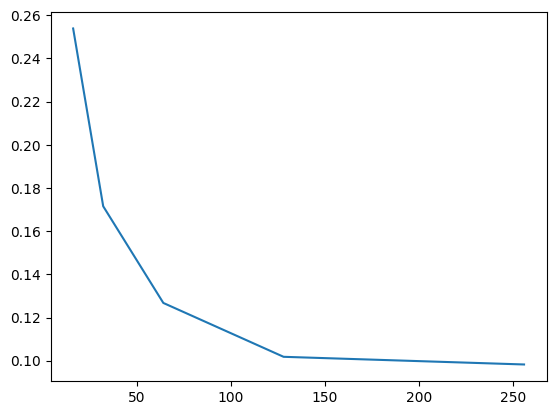

In [10]:
from matplotlib import pyplot as plt

plt.plot(np.array(list(acc_dict.keys())), 1 - np.array(list(acc_dict.values())))

In [11]:
model.sampler

'ancestral'